# Handling time convention in CMIP6 models

## Adjusting time conventions of branched runs
The `historical` and scenario runs for CMIP6 are usually 'branched' from a long control run (usually `experiment_id='piControl'`). This control run is then continued to evaluate and enable the removal of drift in the simulation. To easily remove the drift, the timing  of the runs has to be aligned. Some output in the CMIP6 DECK already follows that convention, whereas some modelling centers opt to keep the time convention for the control run in sequential years since the start. To illustrate this we will pick some data from `MIROC-ES2L` and `GFDL-CM4`.

In [13]:
from dask.distributed import Client

client = Client("tcp://10.32.2.194:44371")
client

Client Scheduler: tcp://10.32.2.194:44371 Dashboard: /user/0000-0001-8571-865x/proxy/40905/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [14]:
%load_ext autoreload
%autoreload 2
import intake
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import matplotlib.pyplot as plt
import cftime

col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")
models = ['MIROC-ES2L', 'GFDL-CM4']
experiments = ['historical', 'piControl']
cat = col.search(variable_id='sos',table_id='Omon', grid_label='gn', experiment_id = experiments, source_id = models, member_id=['r1i1p1f1','r1i1p1f2'])
data_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times':False},preprocess=combined_preprocessing)
# need to reprocess to get consistent cf_time values
data_dict = {k:xr.decode_cf(ds, use_cftime=True) for k, ds in data_dict.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 4 group(s)


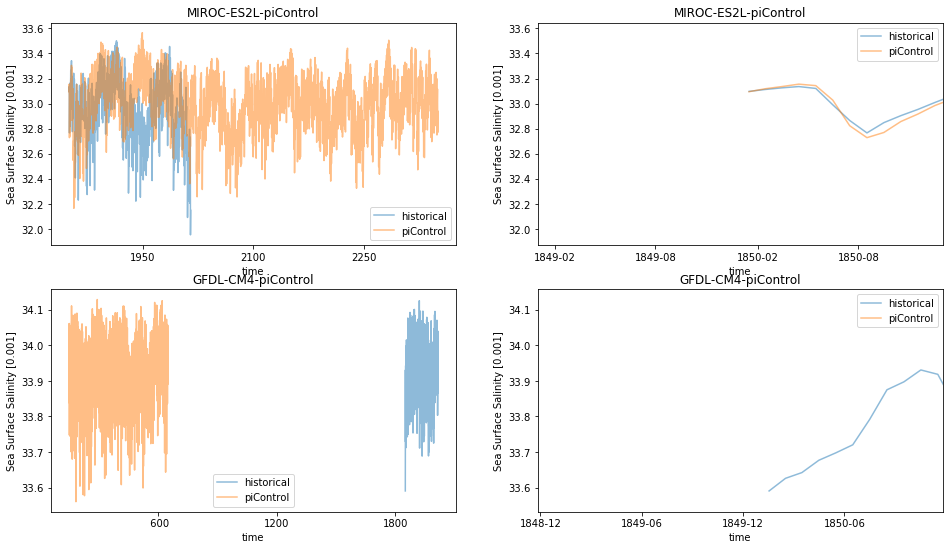

In [15]:
fig, axarr = plt.subplots(ncols=2, nrows=len(models), figsize=[16,9])
in_dict = data_dict
for mi,model in enumerate(models):
    for experiment in experiments:
        ax = axarr[mi,0]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        if experiment == 'historical':
            branch_year = ds.time.data[0].year
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_title(f"{model}-{experiment}")
    ax.legend()
    # zoom in on the branch point
    for experiment in experiments:
        ax = axarr[mi,1]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_xlim([cftime.DatetimeGregorian(branch_year-1, 1, 1), cftime.DatetimeGregorian(branch_year+1, 1, 1)])
    ax.set_title(f"{model}-{experiment}")
    ax.legend()

As you can see the GDFL model uses a different convention for the historical run ('real years') and the piControl run (years since 0).
We can infer the branch point using the metadata of the dataset:


In [16]:
{k:v for k,v in data_dict['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn'].attrs.items() if ('branch' in k) | ('parent' in k)}

{'branch_method': 'standard',
 'branch_time_in_child': 0.0,
 'branch_time_in_parent': 36500.0,
 'parent_activity_id': 'CMIP',
 'parent_experiment_id': 'piControl',
 'parent_mip_era': 'CMIP6',
 'parent_source_id': 'GFDL-CM4',
 'parent_time_units': 'days since 0001-1-1',
 'parent_variant_label': 'r1i1p1f1'}

`cmip6_preprocessing` reads this data and automatically shifts the time convention to the child run for a full dictionary with `unify_branched_time`.
You only have to pass the input `data_dict` and define the branching order. E.g. here the `historical` was branched of the `piControl`. All `piControl` runs will be shifted to the same time convention as the `historical`.

In [17]:
from cmip6_preprocessing.time_utils import unify_branched_time
data_dict_timefixed = unify_branched_time(data_dict, experiment_id_order=['historical', 'piControl'])

/home/jovyan/cmip6_preprocessing/cmip6_preprocessing/time_utils.py:52: UserWarning: No calendar type found in source[MIROC-ES2L]. Applying default.
  


You could add another run in that order, by e.g. passing `experiment_id_order=['spp..','historical', 'piControl']`. This would recursively adjust the time convention of the `historical` to the `spp...` run and then adjust the `piControl` to that same convention as well. Just make sure that the values are ordered from child to parent.

For instance, this doesnt work, because `piControl` is not a child of `historical`

In [19]:
unify_branched_time(data_dict, experiment_id_order=['piControl', 'historical'])

ValueError: Source(GFDL-CM4) not consistent with Target(GFDL-CM4) [source experiment_id: historical | target parent_experiment_id: piControl-spinup]. 

Now lets plot the unified results:

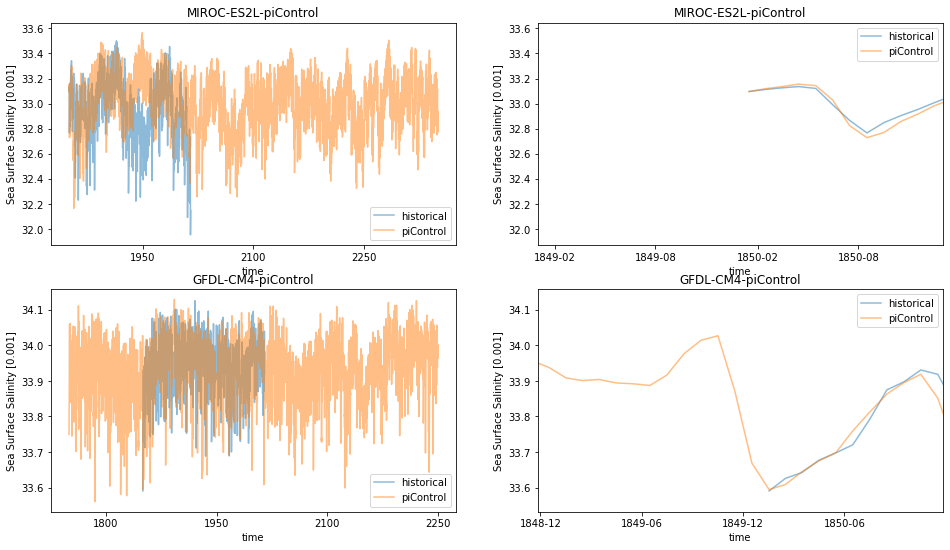

In [18]:
fig, axarr = plt.subplots(ncols=2, nrows=len(models), figsize=[16,9])
in_dict = data_dict_timefixed
for mi,model in enumerate(models):
    for experiment in experiments:
        ax = axarr[mi,0]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        if experiment == 'historical':
            branch_year = ds.time.data[0].year
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_title(f"{model}-{experiment}")
    ax.legend()
    # zoom in on the branch point
    for experiment in experiments:
        ax = axarr[mi,1]
        ds = in_dict[[k for k in data_dict.keys() if (model in k) & (experiment in k)][0]]
        da = ds.sos.isel(x=180, y=250) # these are not the same location in the model but that is fine for the comparison
        da.plot(ax=ax,label=experiment, alpha=0.5)
    ax.set_xlim([cftime.DatetimeGregorian(branch_year-1, 1, 1), cftime.DatetimeGregorian(branch_year+1, 1, 1)])
    ax.set_title(f"{model}-{experiment}")
    ax.legend()

We can see that the `MIROC-ES2L` runs were not affected, since they were already provided in a matching time convention. The `GFDL-CM4` data is now aligned as well and ready for e.g. removing a drift.

![smooth](https://media.giphy.com/media/LOQyoLIojnizS949is/giphy.gif)

Devise a test for this.

In [21]:
# get all models with historical and piControl run

In [39]:
# modified search to check for models with all three (picontrol, historical, 'spss585')
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json")
experiment_ids = ['historical', 'piControl'] #  seems to have the most so far 'ssp119' 'ssp370',,'ssp126' 'spss585' # there are
table_ids = ['Omon'] # , 'Oyr'for the other models the yearly data would give more results but for this combo not
# Note that the yearly files do not have the necessary metadata to shift the control run time!!!

query = dict(experiment_id=experiment_ids, table_id=table_ids)

cat = col.search(**query)
cat.df = cat.df.drop_duplicates(subset=['source_id', 'experiment_id'])

# pick only the ones that have both experiments
models = cat.df['source_id'].unique()
full_models = [] # models that have both experiments available
for model in models:
    df_model = cat.df[cat.df['source_id']==model]
    if set(df_model['experiment_id']) == set(experiment_ids):
        full_models.append(model)
cat.df = cat.df[[(m in full_models) for m in cat.df['source_id'].values]]

data_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times':False})
# need to reprocess to get consistent cf_time values
data_dict = {k:xr.decode_cf(ds, use_cftime=True) for k, ds in data_dict.items()}


Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 74 group(s)


{'CMIP.E3SM-Project.E3SM-1-0.historical.Omon.gr': <xarray.Dataset>
 Dimensions:    (bnds: 2, lat: 180, lon: 360, member_id: 1, time: 1980)
 Coordinates:
     lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
     lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
     time_bnds  (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
   * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
   * member_id  (member_id) <U8 'r1i1p1f1'
 Dimensions without coordinates: bnds
 Data variables:
     hfds       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 596, 180, 360), meta=np.ndarray>
 Attributes:
     Conventions:                    CF-1.7 CMIP-6.2
     activity_id:                    CMIP
     branch_method:                  sta

In [46]:
from cmip6_preprocessing.time_utils import unify_branched_time
data_dict_timefixed = unify_branched_time(data_dict, experiment_id_order=['historical', 'piControl'])

/home/jovyan/cmip6_preprocessing/cmip6_preprocessing/time_utils.py:53: UserWarning: No calendar type found in source[ACCESS-CM2]. Applying default.
  warnings.warn(f"No calendar type found in source[{source.attrs['source_id']}]. Applying default.")
/home/jovyan/cmip6_preprocessing/cmip6_preprocessing/time_utils.py:53: UserWarning: No calendar type found in source[ACCESS-ESM1-5]. Applying default.
  warnings.warn(f"No calendar type found in source[{source.attrs['source_id']}]. Applying default.")
/home/jovyan/cmip6_preprocessing/cmip6_preprocessing/time_utils.py:53: UserWarning: No calendar type found in source[AWI-CM-1-1-MR]. Applying default.
  warnings.warn(f"No calendar type found in source[{source.attrs['source_id']}]. Applying default.")
/home/jovyan/cmip6_preprocessing/cmip6_preprocessing/time_utils.py:53: UserWarning: No calendar type found in source[BCC-CSM2-MR]. Applying default.
  warnings.warn(f"No calendar type found in source[{source.attrs['source_id']}]. Applying default.

{'Conventions': 'CF-1.7 CMIP-6.2',
 'activity_id': 'CMIP',
 'branch_method': 'standard',
 'branch_time_in_child': 0.0,
 'branch_time_in_parent': 182622.0,
 'creation_date': '2018-12-18T12:00:00Z',
 'data_specs_version': '01.00.27',
 'experiment': 'piControl',
 'experiment_id': 'piControl',
 'forcing_index': 1,
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.AWI.AWI-CM-1-1-MR.piControl.none.r1i1p1f1',
 'grid': 'FESOM 1.4 (unstructured grid in the horizontal with 830305 wet nodes; 46 levels; top grid cell 0-5 m)',
 'grid_label': 'gn',
 'initialization_index': 1,
 'institution': 'Alfred Wegener Institute, Helmholtz Centre for Polar and Marine Research, Am Handelshafen 12, 27570 Bremerhaven, Germany',
 'institution_id': 'AWI',
 'license': 'CMIP6 model data produced by Alfred Wegener Institute, Helmholtz Centre for Polar and Marine Research, Am Handelshafen 12, 27570 Bremerhaven, Germany is licensed under a Creative Commons Attribution-ShareAlike 4.0 Internat

In [95]:
hist_raw.attrs

{'CCCma_model_hash': '55f484f90aff0e32c5a8e92a42c6b9ae7ffe6224',
 'CCCma_parent_runid': 'rc3.1-pictrl',
 'CCCma_pycmor_hash': 'd7b3a2b74b3d7ea5b882fe60f49744343d56f879',
 'CCCma_runid': 'rc3.1-his10',
 'Conventions': 'CF-1.7 CMIP-6.2',
 'YMDH_branch_time_in_child': '1850:01:01:00',
 'YMDH_branch_time_in_parent': '5651:01:01:00',
 'activity_id': 'CMIP',
 'branch_method': 'Spin-up documentation',
 'branch_time_in_child': 0.0,
 'branch_time_in_parent': 1387365.0,
 'cmor_version': '3.4.0',
 'contact': 'ec.cccma.info-info.ccmac.ec@canada.ca',
 'creation_date': '2019-04-10T00:20:09Z',
 'data_specs_version': '01.00.29',
 'experiment': 'all-forcing simulation of the recent past',
 'experiment_id': 'historical',
 'external_variables': 'areacello volcello',
 'forcing_index': 1,
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.CCCma.CanESM5.historical.none.r10i1p1f1',
 'grid': 'ORCA1 tripolar grid, 1 deg with refinement to 1/3 deg within 20 degrees of the equator; 3

In [110]:
# more test'y version

# do the actual processing in the function? That will take forever...

for model in full_models:
    hist = data_dict_timefixed[[k for k in data_dict.keys() if (model in k) & ('historical' in k)][0]]
    cont = data_dict_timefixed[[k for k in data_dict.keys() if (model in k) & ('piControl' in k)][0]]

    hist_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('historical' in k)][0]]
    cont_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('piControl' in k)][0]]
    
    # make assert later
    try:
        assert cont.time[0]<=hist.time[0]
        assert cont.time[-1] >= hist.time[-1]
    except Exception as e:
        print(model)
        print(e)

CanESM5

CNRM-CM6-1
cannot compare cftime.DatetimeProlepticGregorian(1431-01-16 12:00:00) and cftime.DatetimeGregorian(1850-01-16 12:00:00) (different calendars)
EC-Earth3
cannot compare cftime.DatetimeGregorian(1850-01-16 12:00:00) and cftime.DatetimeProlepticGregorian(1850-01-16 12:00:00) (different calendars)
MPI-ESM1-2-HR

NorCPM1



Ok lets go throug them 1 by 1:
first CanESM4

<Figure size 432x288 with 0 Axes>

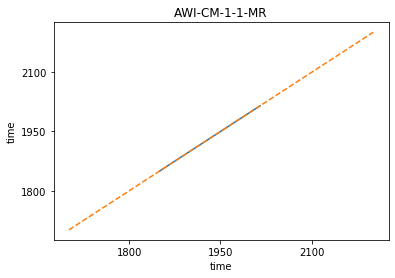

<Figure size 432x288 with 0 Axes>

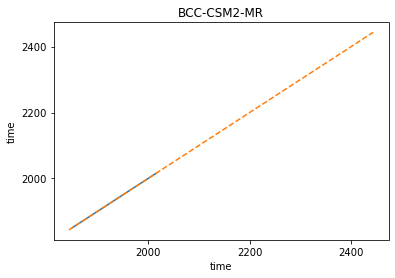

<Figure size 432x288 with 0 Axes>

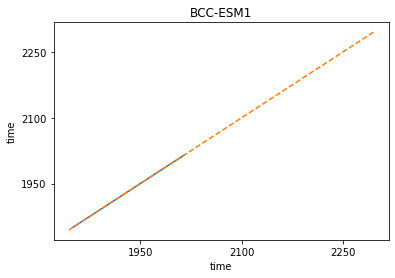

<Figure size 432x288 with 0 Axes>

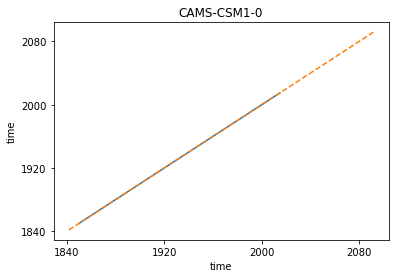

<Figure size 432x288 with 0 Axes>

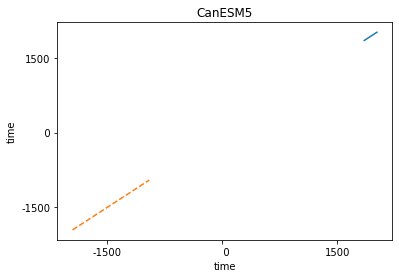

<Figure size 432x288 with 0 Axes>

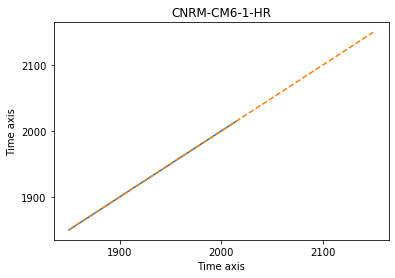

<Figure size 432x288 with 0 Axes>

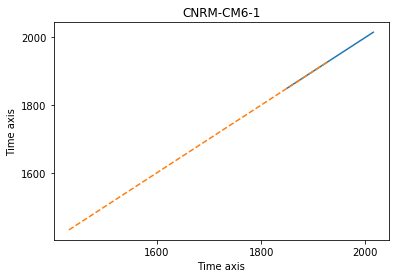

<Figure size 432x288 with 0 Axes>

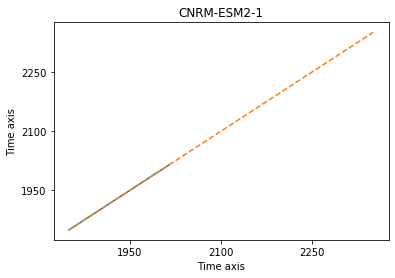

<Figure size 432x288 with 0 Axes>

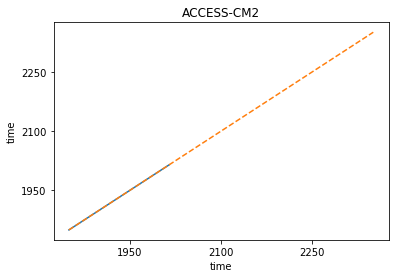

<Figure size 432x288 with 0 Axes>

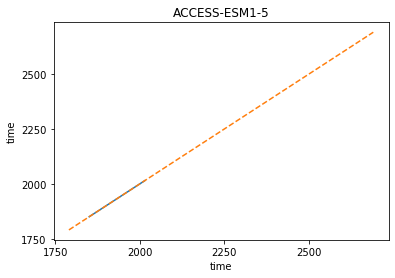

<Figure size 432x288 with 0 Axes>

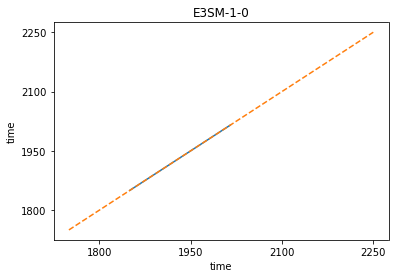

<Figure size 432x288 with 0 Axes>

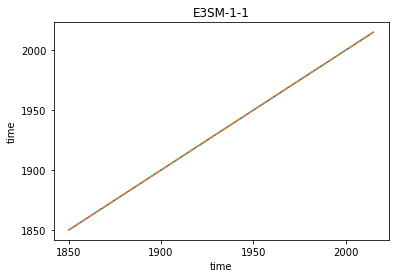

<Figure size 432x288 with 0 Axes>

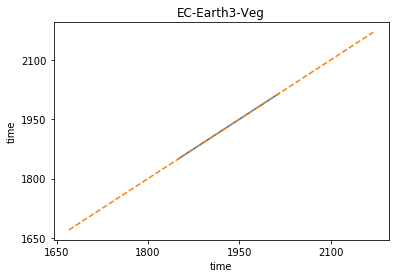

<Figure size 432x288 with 0 Axes>

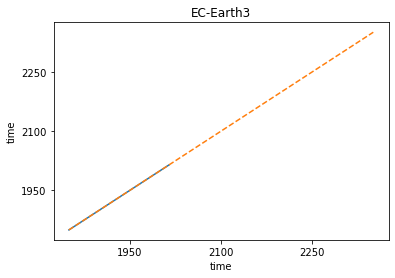

<Figure size 432x288 with 0 Axes>

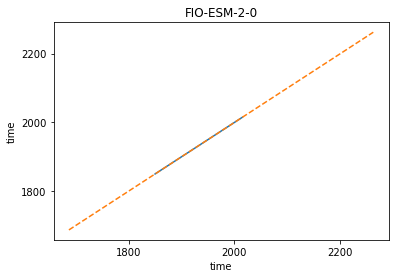

<Figure size 432x288 with 0 Axes>

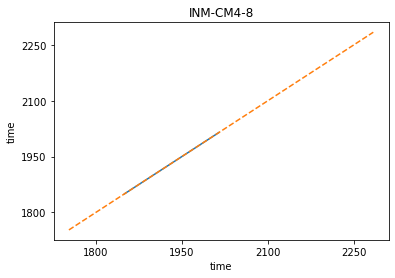

<Figure size 432x288 with 0 Axes>

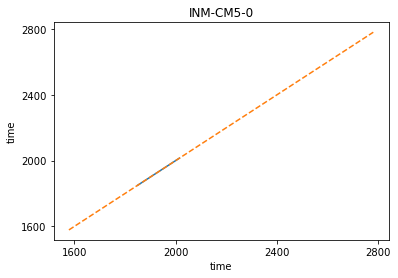

<Figure size 432x288 with 0 Axes>

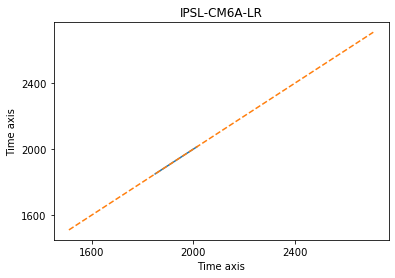

<Figure size 432x288 with 0 Axes>

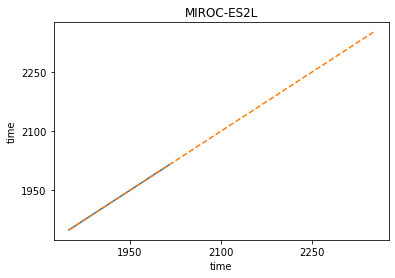

<Figure size 432x288 with 0 Axes>

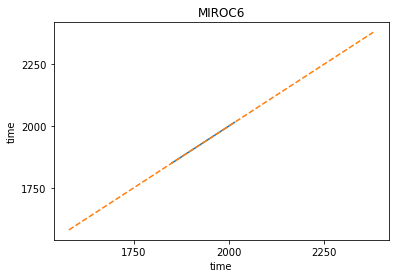

<Figure size 432x288 with 0 Axes>

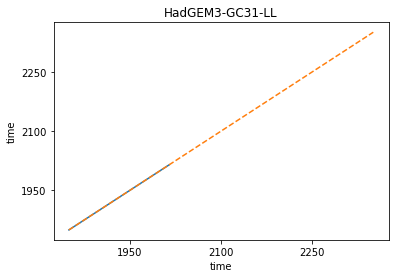

<Figure size 432x288 with 0 Axes>

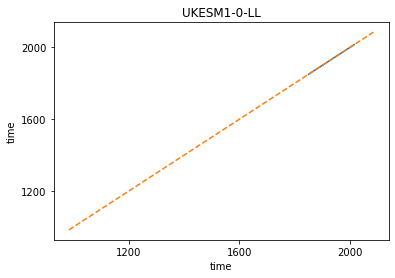

<Figure size 432x288 with 0 Axes>

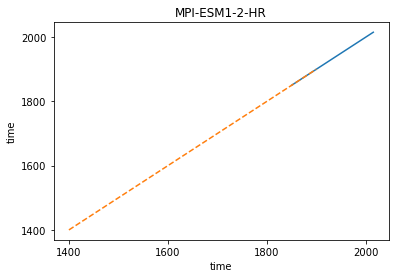

<Figure size 432x288 with 0 Axes>

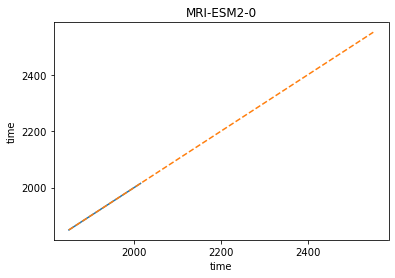

<Figure size 432x288 with 0 Axes>

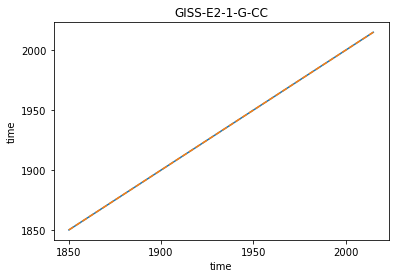

<Figure size 432x288 with 0 Axes>

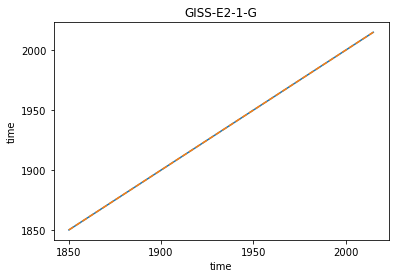

<Figure size 432x288 with 0 Axes>

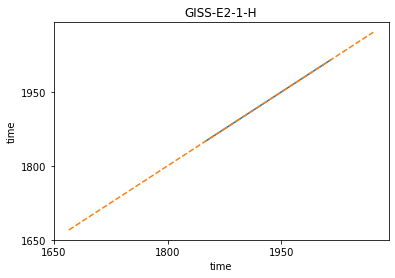

<Figure size 432x288 with 0 Axes>

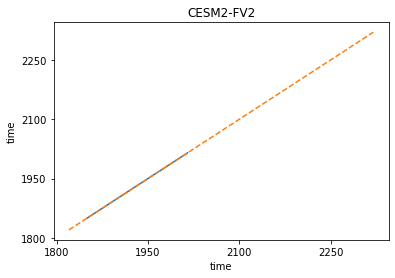

<Figure size 432x288 with 0 Axes>

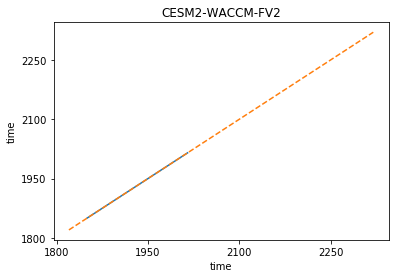

<Figure size 432x288 with 0 Axes>

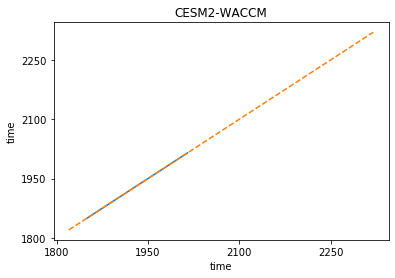

<Figure size 432x288 with 0 Axes>

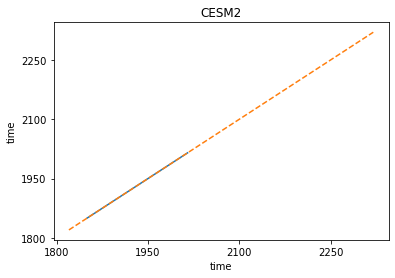

<Figure size 432x288 with 0 Axes>

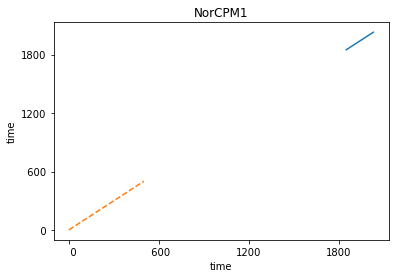

<Figure size 432x288 with 0 Axes>

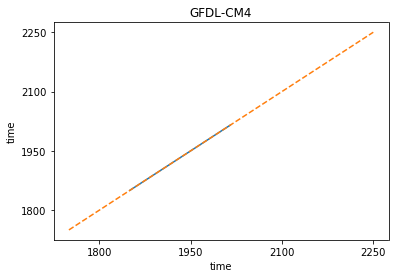

<Figure size 432x288 with 0 Axes>

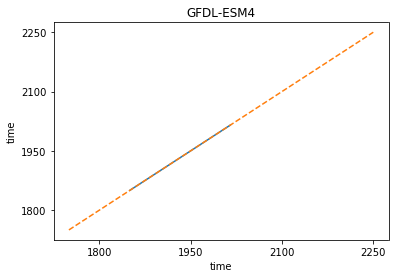

<Figure size 432x288 with 0 Axes>

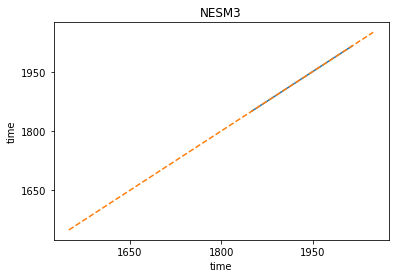

<Figure size 432x288 with 0 Axes>

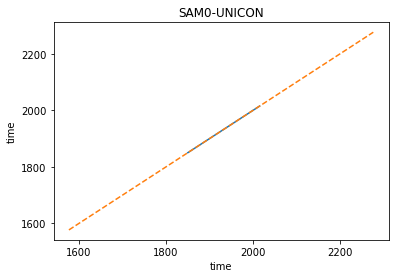

<Figure size 432x288 with 0 Axes>

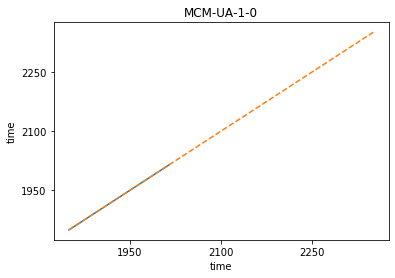

In [107]:
from cmip6_preprocessing.time_utils import _decode_wrapper
for model in full_models:

    hist = data_dict_timefixed[[k for k in data_dict.keys() if (model in k) & ('historical' in k)][0]]
    cont = data_dict_timefixed[[k for k in data_dict.keys() if (model in k) & ('piControl' in k)][0]]

    hist_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('historical' in k)][0]]
    cont_raw = data_dict[[k for k in data_dict.keys() if (model in k) & ('piControl' in k)][0]]
    plt.figure()
    try:
#         print(model)

#         # find branchpoint based on new time
#         branch_idx = abs(cont.time - hist.time[0]).argmin()
#         print(hist.time.data[0])
#         print(cont.time[branch_idx].data)
#         print(cont.time)
#     #     assert hist.time.data[0].year == cont.time.data[branch_idx].year
#     #     assert hist.time.data[0].month == cont.time.data[branch_idx].month
#         # they might not match exactly

#         print({k:v for k,v in hist_raw.attrs.items() if ('branch' in k) | ('parent' in k)})

#         branch_time_source = xr.DataArray(hist_raw.attrs['branch_time_in_parent'])
#         branch_time_source.attrs = hist_raw.time.attrs

#         calendar_type = None # if not changed this will default to gregorian
#         if 'calendar_type' in branch_time_source.attrs.keys():
#             calendar_type = source.time.attrs['calendar_type']

#         if calendar_type:
#             branch_time_source.attrs['calendar'] = calendar_type

#         branch_time_source.attrs['units'] = hist_raw.attrs['parent_time_units']
#         branch_time_source = _decode_wrapper(branch_time_source)
#         # find branch time 

#         print(f"Detected branch time in control:{branch_time_source.data}")

        plt.figure()
        hist.time.plot()
        cont.time.plot(ls='--')
       
    except:
        pass
    
    plt.title(model)
    plt.show()
        

In [102]:
cont_raw.time

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(1431-01-16 12:00:00),
       cftime.DatetimeProlepticGregorian(1431-02-15 00:00:00),
       cftime.DatetimeProlepticGregorian(1431-03-16 12:00:00), ...,
       cftime.DatetimeProlepticGregorian(1930-10-16 12:00:00),
       cftime.DatetimeProlepticGregorian(1930-11-16 00:00:00),
       cftime.DatetimeProlepticGregorian(1930-12-16 12:00:00)], dtype=object)
Coordinates:
  * time     (time) object 1431-01-16 12:00:00 ... 1930-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      Time axis
    standard_name:  time
    time_origin:    1850-01-01 00:00:00

In [101]:
hist_raw.time

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeGregorian(1850-01-16 12:00:00),
       cftime.DatetimeGregorian(1850-02-15 00:00:00),
       cftime.DatetimeGregorian(1850-03-16 12:00:00), ...,
       cftime.DatetimeGregorian(2014-10-16 12:00:00),
       cftime.DatetimeGregorian(2014-11-16 00:00:00),
       cftime.DatetimeGregorian(2014-12-16 12:00:00)], dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      Time axis
    standard_name:  time
    time_origin:    1850-01-01 00:00:00

In [86]:
cont_raw.time.data[0]

cftime.DatetimeProlepticGregorian(1701-01-16 12:00:00)

In [82]:
branch_time_adjusted + hist_raw.time[0].data

TypeError: unsupported operand type(s) for +: 'cftime._cftime.DatetimeProlepticGregorian' and 'cftime._cftime.DatetimeProlepticGregorian'

In [83]:
hist_raw.time[0].data

array(cftime.DatetimeProlepticGregorian(1850-01-16 12:00:00), dtype=object)

In [84]:
branch_time_adjusted

cftime.DatetimeProlepticGregorian(1850-01-16 12:00:00)